# Comparing Unsupervised Learning Results to Network Position

In this notebook, we use the 'G03B_attribute_centrality_position.csv' dataset to apply various unsupervised learning methods to explore the underlying group structure of data points using node-level features, including attributes and centralities. Additionally, we compare these clustering results with network positions, which are classifications based on network characteristics (components and communities). We will demonstrate that the underlying group structure varies significantly depending on the perspective used to inspect the data, highlighting the differences between classifications based on network structure and groups based on node-level features.

In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\user\Documents\G03B_attribute_centrality_position.csv", index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 364
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   專利權人            365 non-null    object 
 1   專利件數            365 non-null    int64  
 2   他人引證次數          365 non-null    int64  
 3   自我引證次數          365 non-null    int64  
 4   發明人數            365 non-null    int64  
 5   平均專利年齡          365 non-null    int64  
 6   活動年期            365 non-null    int64  
 7   相對研發能力          329 non-null    float64
 8   國家              365 non-null    object 
 9   時期              365 non-null    object 
 10  indegree        253 non-null    float64
 11  closeness       253 non-null    float64
 12  betweenness     253 non-null    float64
 13  harmonic        253 non-null    float64
 14  eigenvector     253 non-null    float64
 15  katz            253 non-null    float64
 16  pagerank        253 non-null    float64
 17  laplacian       253 non-null    float64


In [2]:
df = df.fillna(0)
df.loc[df['position_class'] == 0, 'position_class'] = 'not included'

## Visualizing Data Cluster with first 2 Principal Component

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

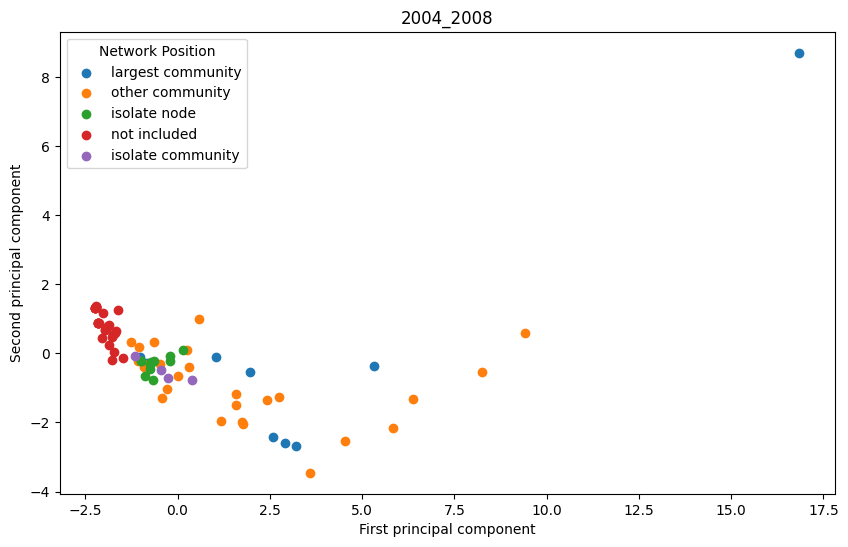

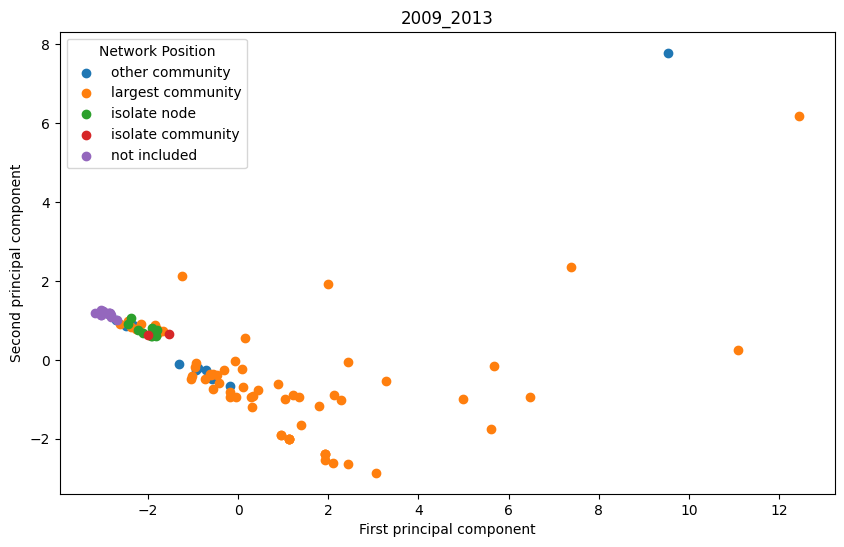

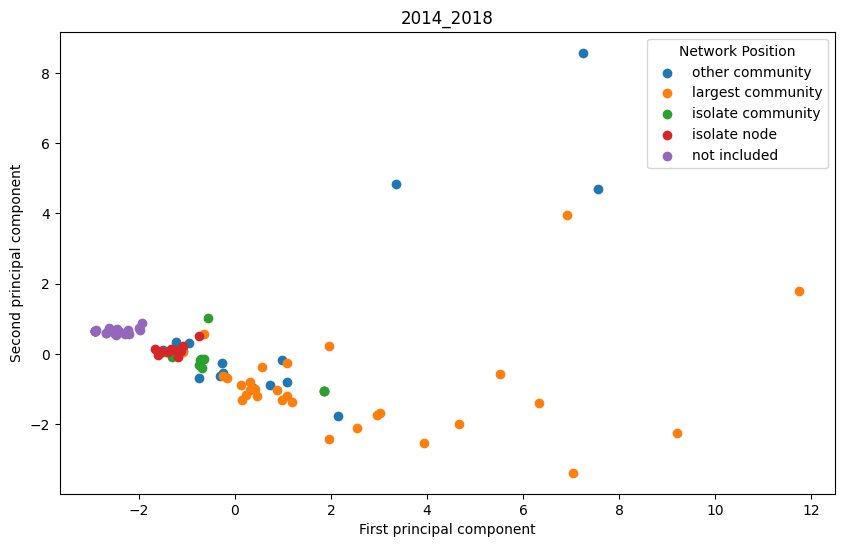

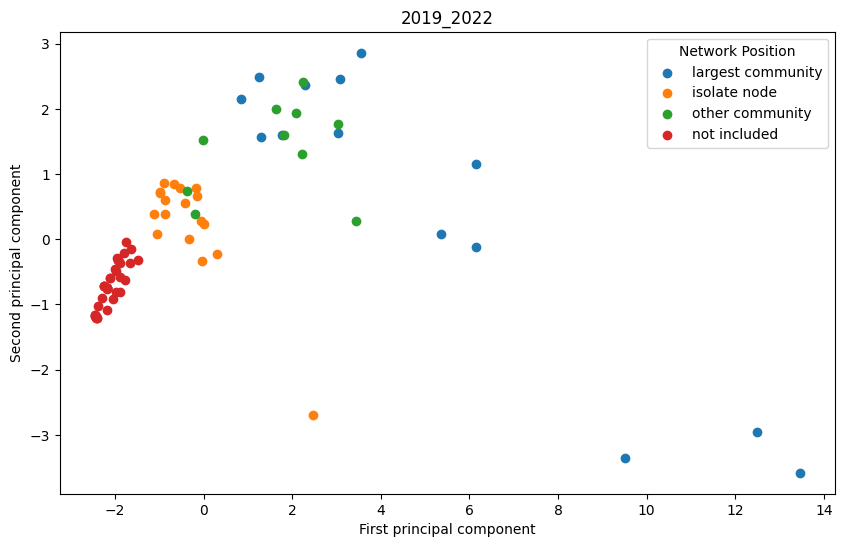

In [5]:
period_list = ['2004_2008', '2009_2013', '2014_2018', '2019_2022']

for p in period_list:
    # extract period
    df_p = df.loc[df['時期']==p,]
    df_p = df_p.drop(['專利權人','國家','時期','position_class'], axis = 1)

    # scale data
    scaler = StandardScaler()
    scaler.fit(df_p)
    X_scaled = scaler.transform(df_p)

    # transform data onto the first two principal components
    pca = PCA(n_components=2)
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    # 2 pc and network position df
    df_pca = pd.DataFrame(X_pca)
    df_label = df.loc[df['時期']==p,'position_class'].reset_index(drop=True)
    df_draw = pd.concat([df_pca, df_label], axis = 1)
    df_draw.columns = ['1pc','2pc','label']
    
    # plot first vs. second principal component
    # Map labels to colors
    unique_labels = df_draw['label'].unique()
    colors = plt.cm.tab10(range(len(unique_labels))) # Get a colormap
    label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create the scatter plot with colors
    plt.figure(figsize=(10, 6))
    for label in unique_labels:
        subset = df_draw.loc[df_draw['label'] == label,]
        plt.scatter(subset['1pc'], subset['2pc'], c=[label_color_map[label]], label=label)
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    #plt.xlim(min(df_draw['1pc'])-1, max(df_draw['1pc'])+1)
    #plt.ylim(min(df_draw['2pc'])-1, max(df_draw['2pc'])+1)
    plt.legend(title='Network Position')
    plt.title(f'{p}')

## Visualizing Data Cluster with Manifold Learning: t_SNE

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

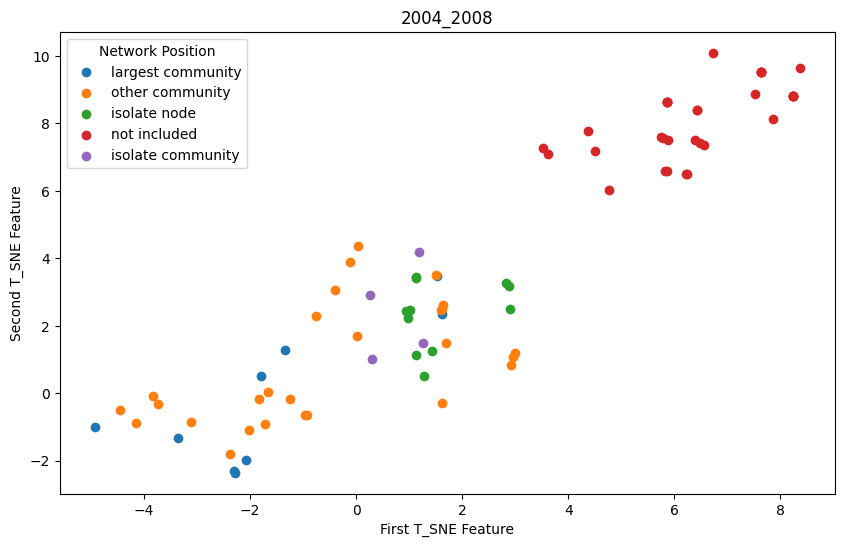

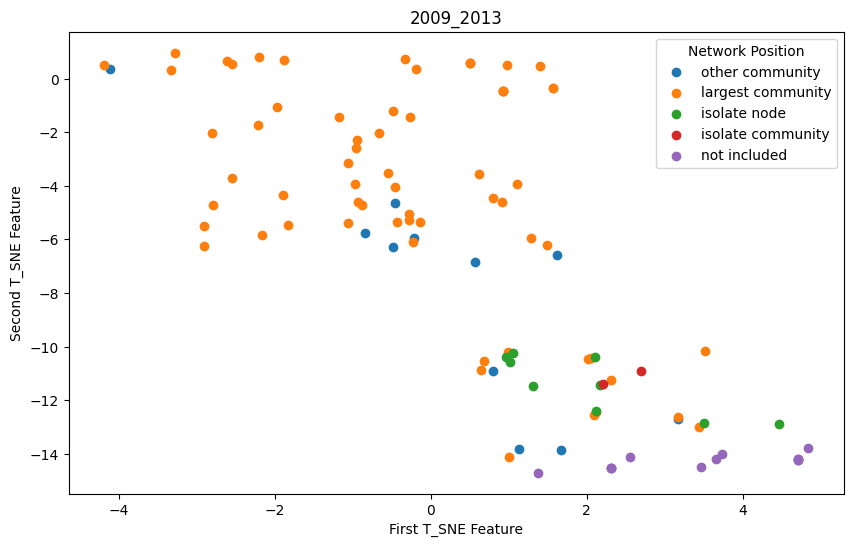

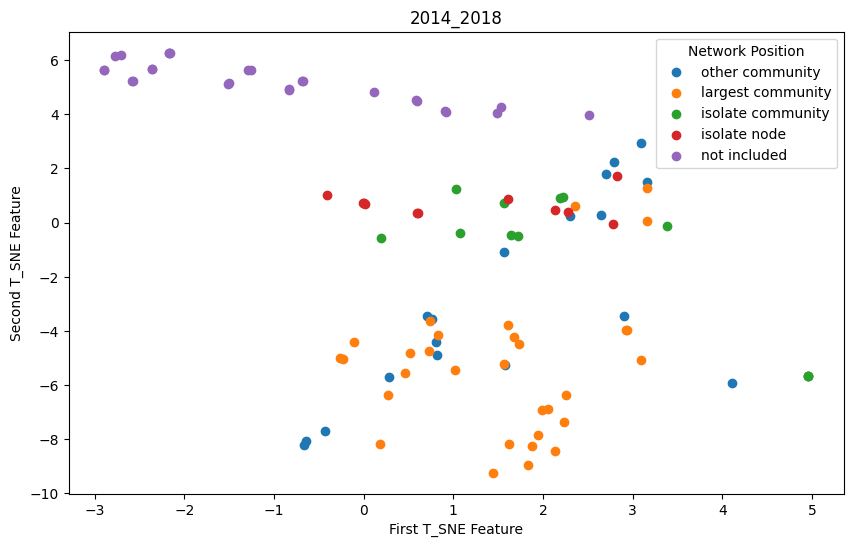

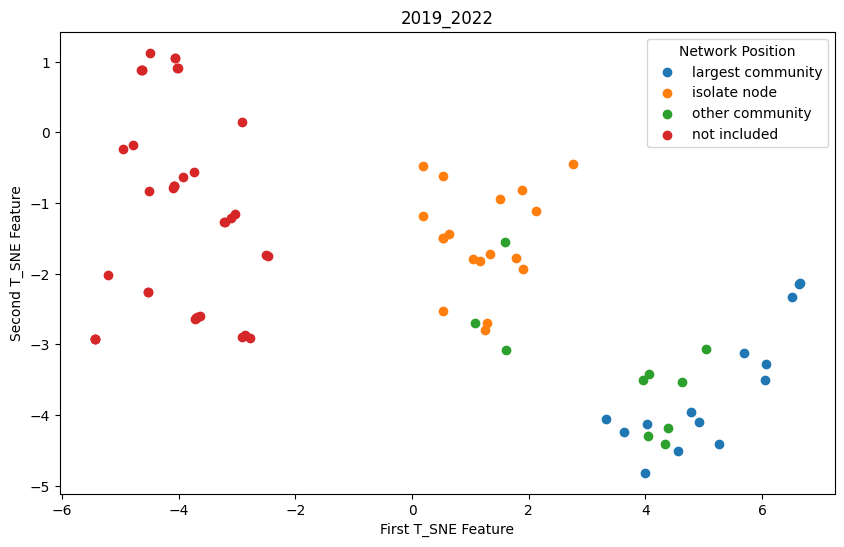

In [7]:
for p in ['2004_2008','2009_2013','2014_2018','2019_2022']:
    # extract period
    df_p = df.loc[df['時期']==p,]
    df_p = df_p.drop(['專利權人','國家','時期','position_class'], axis = 1)

    # scale data
    scaler = StandardScaler()
    scaler.fit(df_p)
    X_scaled = scaler.transform(df_p)

    # t-SNE transform
    tsne = TSNE(random_state=42)
    X = tsne.fit_transform(X_scaled)

    # 2 tsne features and network position df
    df_tsne = pd.DataFrame(X)
    df_label = df.loc[df['時期']==p,'position_class'].reset_index(drop=True)
    df_draw = pd.concat([df_tsne, df_label], axis = 1)
    df_draw.columns = ['1tsne','2tsne','label']
    
    # plot first vs. second T-SNE features
    # Map labels to colors
    unique_labels = df_draw['label'].unique()
    colors = plt.cm.tab10(range(len(unique_labels))) # Get a colormap
    label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create the scatter plot with colors
    plt.figure(figsize=(10, 6))
    for label in unique_labels:
        subset = df_draw.loc[df_draw['label'] == label,]
        plt.scatter(subset['1tsne'], subset['2tsne'], c=[label_color_map[label]], label=label)
    plt.xlabel("First T_SNE Feature")
    plt.ylabel("Second T_SNE Feature")
    plt.legend(title='Network Position')
    plt.title(f'{p}')

Upon analyzing the visualization results displayed above, we observed that the T-SNE manifold learning algorithm outperforms PCA in capturing the underlying group structures. The clustering results produced by T-SNE align more closely with network position classification, particularly in distinguishing 'not included', 'isolated', and other classes. However, it still struggles to differentiate between the 'largest community' and 'other community'.

## K-mean Clustering and Network Position

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score


In [9]:
period_list = ['2004_2008', '2009_2013', '2014_2018', '2019_2022']
result_df = pd.DataFrame()
for p in period_list:
    # extract period
    df_p = df.loc[df['時期']==p,]
    df_p = df_p.drop(['專利權人','國家','時期','position_class'], axis = 1)

    # Scale the data
    scaler = StandardScaler()
    df_p = scaler.fit_transform(df_p)

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=0)
    df_temp = pd.DataFrame({'cluster':kmeans.fit_predict(df_p)})

    # Convert original labels to numeric values for comparison
    df_label = df.loc[df['時期']==p,'position_class'].reset_index(drop=True)
    label_map = {label: idx for idx, label in enumerate(df_label.unique())}
    df_temp['label_num'] = df_label.map(label_map)

    # Calculate similarity metrics
    ari = adjusted_rand_score(df_temp['label_num'], df_temp['cluster'])
    nmi = normalized_mutual_info_score(df_temp['label_num'], df_temp['cluster'])
    homogeneity = homogeneity_score(df_temp['label_num'], df_temp['cluster'])
    completeness = completeness_score(df_temp['label_num'], df_temp['cluster'])
    v_measure = v_measure_score(df_temp['label_num'], df_temp['cluster'])


    clustering_similarity_df = pd.DataFrame({'Period': [p],
                                             'Adjusted Rand Index (ARI)': [ari],
                                             'Normalized Mutual Information (NMI)': [nmi],
                                             'Homogeneity': [homogeneity],
                                             'Completeness': [completeness],
                                             'V-Measure': [v_measure]})
    result_df = pd.concat([result_df,clustering_similarity_df ], axis = 0)

display(result_df.T)


,0,0,0,0
Period,2004_2008,2009_2013,2014_2018,2019_2022
Adjusted Rand Index (ARI),0.594303,0.145085,0.33644,0.861942
Normalized Mutual Information (NMI),0.610452,0.281307,0.485156,0.787522
Homogeneity,0.587298,0.328811,0.464145,0.796456
Completeness,0.635506,0.245796,0.50816,0.778786
V-Measure,0.610452,0.281307,0.485156,0.787522


Using these similarity metrics, we can assess the similarity between k-means clustering results and network position classes. All these metrics exhibit a consistent trend: they tend to be lower during the middle two periods and higher in the first and last periods. Given that the network structure was denser and more complex during the middle two periods, we can infer that network group structure is more challenging to capture through node-level feature clustering when the network is in a thriving stage of development. Conversely, it is easier to capture when the network structure is relatively simple, as in the beginning or mature stages.

## Agglomerative Clustering and Network Position

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

In [11]:
period_list = ['2004_2008', '2009_2013', '2014_2018', '2019_2022']
result_df = pd.DataFrame()
for p in period_list:
    # extract period
    df_p = df.loc[df['時期']==p,]
    df_p = df_p.drop(['專利權人','國家','時期','position_class'], axis = 1)

    # Scale the data
    scaler = StandardScaler()
    df_p = scaler.fit_transform(df_p)

    # Perform Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average')
    df_temp = pd.DataFrame({'cluster':agg_clustering.fit_predict(df_p)})

    # Convert original labels to numeric values for comparison
    df_label = df.loc[df['時期']==p,'position_class'].reset_index(drop=True)
    label_map = {label: idx for idx, label in enumerate(df_label.unique())}
    df_temp['label_num'] = df_label.map(label_map)

    # Calculate similarity metrics
    ari = adjusted_rand_score(df_temp['label_num'], df_temp['cluster'])
    nmi = normalized_mutual_info_score(df_temp['label_num'], df_temp['cluster'])
    homogeneity = homogeneity_score(df_temp['label_num'], df_temp['cluster'])
    completeness = completeness_score(df_temp['label_num'], df_temp['cluster'])
    v_measure = v_measure_score(df_temp['label_num'], df_temp['cluster'])


    clustering_similarity_df = pd.DataFrame({'Period': [p],
                                             'Adjusted Rand Index (ARI)': [ari],
                                             'Normalized Mutual Information (NMI)': [nmi],
                                             'Homogeneity': [homogeneity],
                                             'Completeness': [completeness],
                                             'V-Measure': [v_measure]})
    result_df = pd.concat([result_df,clustering_similarity_df ], axis = 0)

display(result_df.T)

,0,0,0,0
Period,2004_2008,2009_2013,2014_2018,2019_2022
Adjusted Rand Index (ARI),0.151938,-0.063397,-0.003307,0.422642
Normalized Mutual Information (NMI),0.286377,0.072991,0.08183,0.524628
Homogeneity,0.220134,0.048763,0.049196,0.423474
Completeness,0.409647,0.145066,0.243071,0.689272
V-Measure,0.286377,0.072991,0.08183,0.524628


Since we set the number of clusters to 5 in both k-means and agglomerative clustering, matching the number of network positions, we observed the same trend in these similarity metrics when using agglomerative clustering as we did with k-means clustering.

## DBSCAN and Network Position

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

In [13]:
period_list = ['2004_2008', '2009_2013', '2014_2018', '2019_2022']
result_df = pd.DataFrame()
for p in period_list:
    # extract period
    df_p = df.loc[df['時期']==p,]
    df_p = df_p.drop(['專利權人','國家','時期','position_class'], axis = 1)

    # Scale the data
    scaler = StandardScaler()
    df_p = scaler.fit_transform(df_p)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=1.5, min_samples=10)
    df_temp = pd.DataFrame({'cluster':dbscan.fit_predict(df_p)})

    # Filter out noise points (-1) for metrics calculation
    df_temp = df_temp[df_temp['cluster'] != -1]

    # Convert original labels to numeric values for comparison
    df_label = df.loc[df['時期']==p,'position_class'].reset_index(drop=True)
    label_map = {label: idx for idx, label in enumerate(df_label.unique())}
    df_temp['label_num'] = df_label.map(label_map)

    # Calculate similarity metrics
    ari = adjusted_rand_score(df_temp['label_num'], df_temp['cluster'])
    nmi = normalized_mutual_info_score(df_temp['label_num'], df_temp['cluster'])
    homogeneity = homogeneity_score(df_temp['label_num'], df_temp['cluster'])
    completeness = completeness_score(df_temp['label_num'], df_temp['cluster'])
    v_measure = v_measure_score(df_temp['label_num'], df_temp['cluster'])


    clustering_similarity_df = pd.DataFrame({'Period': [p],
                                             'Adjusted Rand Index (ARI)': [ari],
                                             'Normalized Mutual Information (NMI)': [nmi],
                                             'Homogeneity': [homogeneity],
                                             'Completeness': [completeness],
                                             'V-Measure': [v_measure]})
    result_df = pd.concat([result_df,clustering_similarity_df ], axis = 0)

display(result_df.T)

,0,0,0,0
Period,2004_2008,2009_2013,2014_2018,2019_2022
Adjusted Rand Index (ARI),0.73445,0.345856,0.591623,0.976187
Normalized Mutual Information (NMI),0.719085,0.517478,0.662582,0.944327
Homogeneity,0.561383,0.464442,0.565454,0.894526
Completeness,1.0,0.58419,0.799998,1.0
V-Measure,0.719085,0.517478,0.662582,0.944327


Similar trends emerged when using DBSCAN clustering, but with significantly higher similarity metric values. DBSCAN's ability to identify nonconvex cluster shapes and classify some points as noise, rather than forcing them into clusters, allows for more flexible group structure discovery. By setting 'eps' to 1.5 and 'min_samples' to 10, we achieved results where some metric values were equal to or very close to 1. This indicates that DBSCAN is a more powerful clustering algorithm than k-means and agglomerative clustering when using network position as ground truth label.

### Use t-SNE transformed 2D feature space to visualize and compare DBSCAN clustering result and network position.

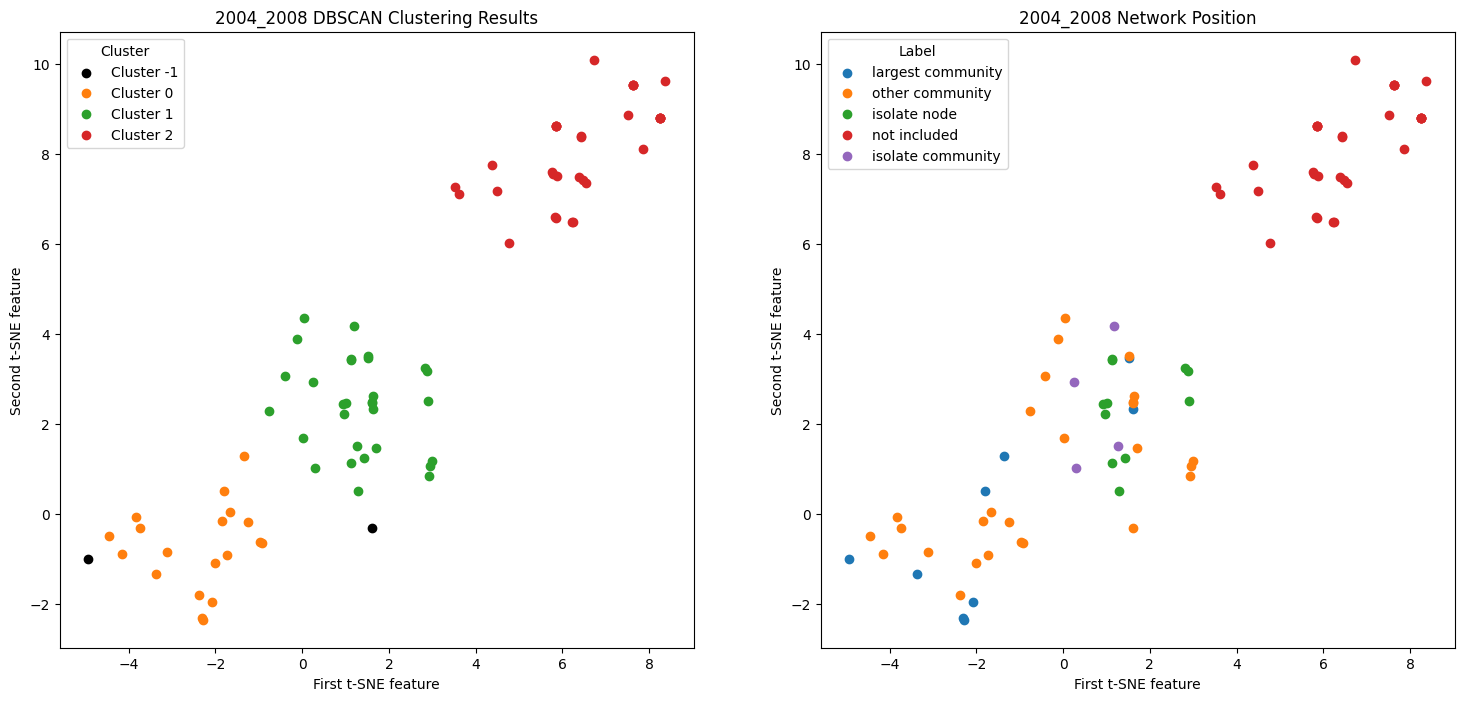

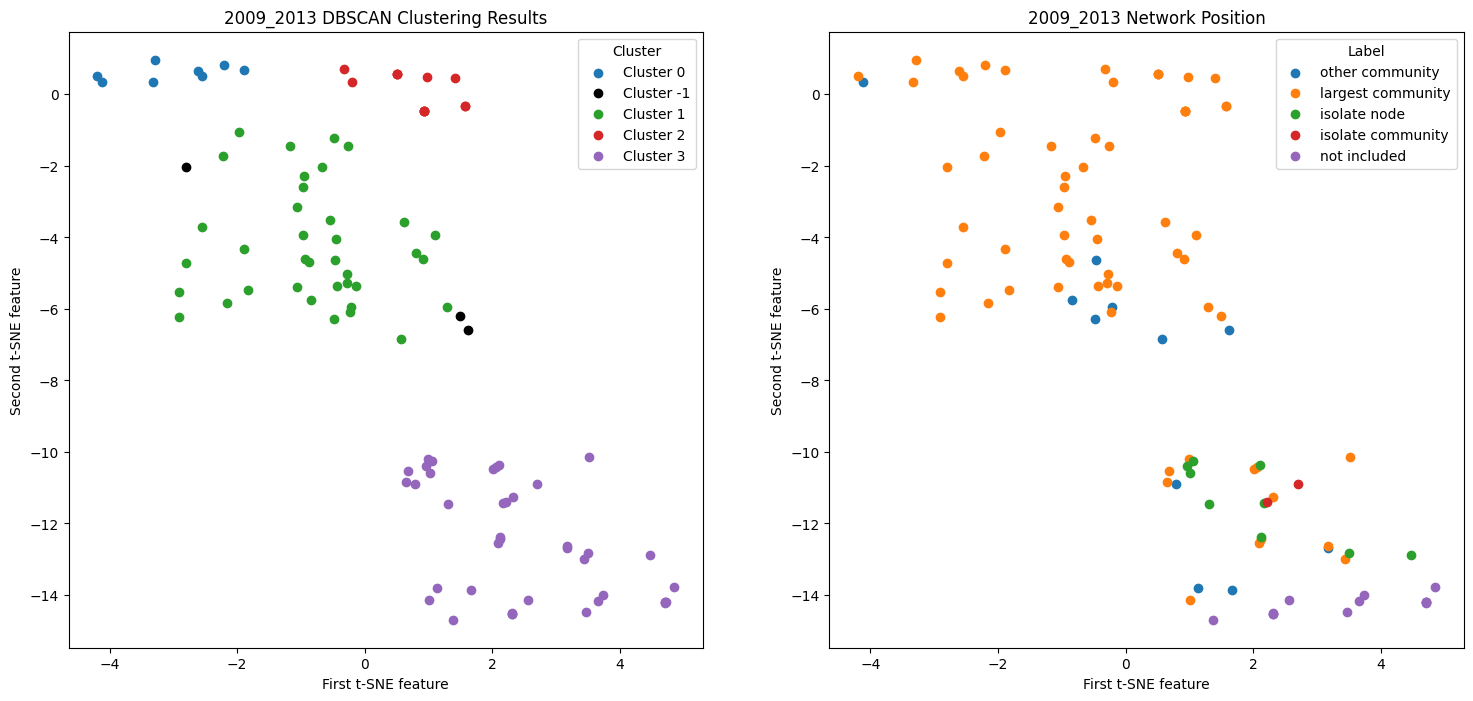

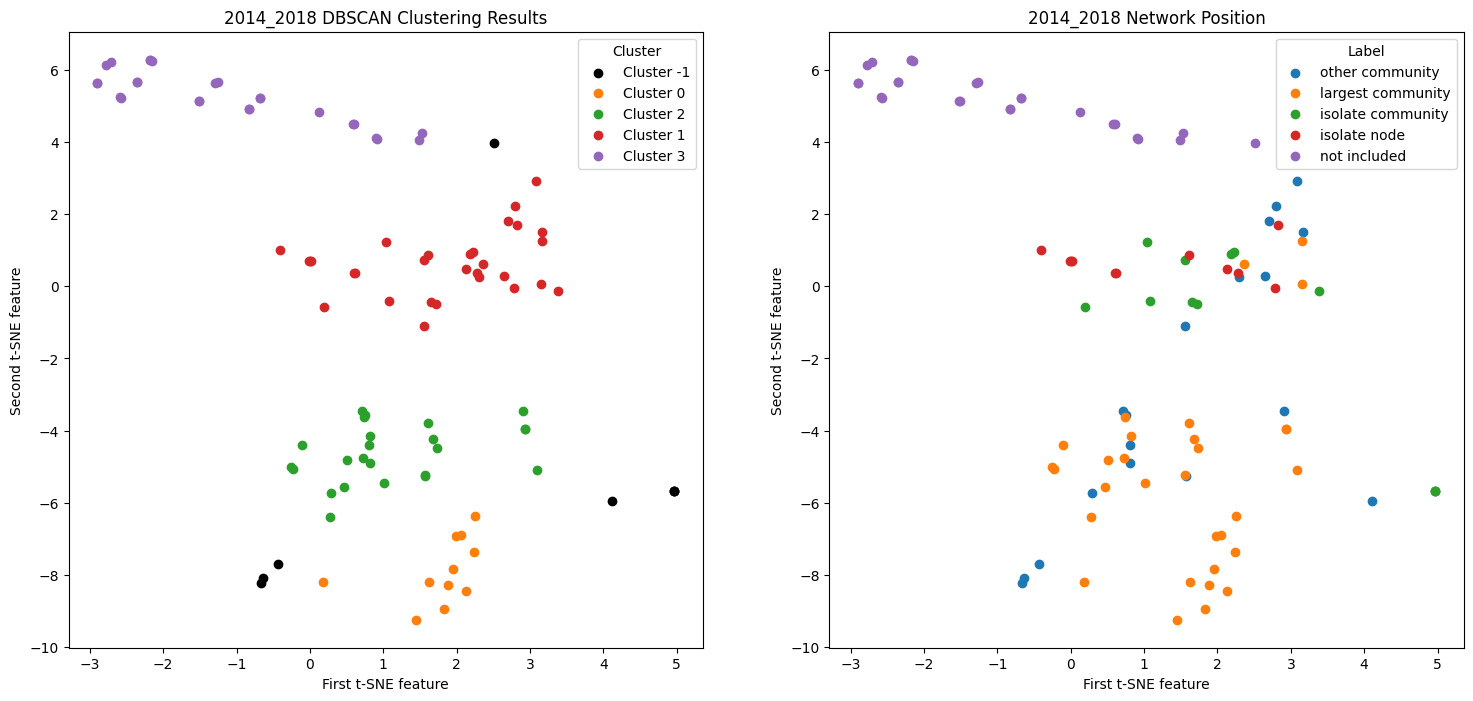

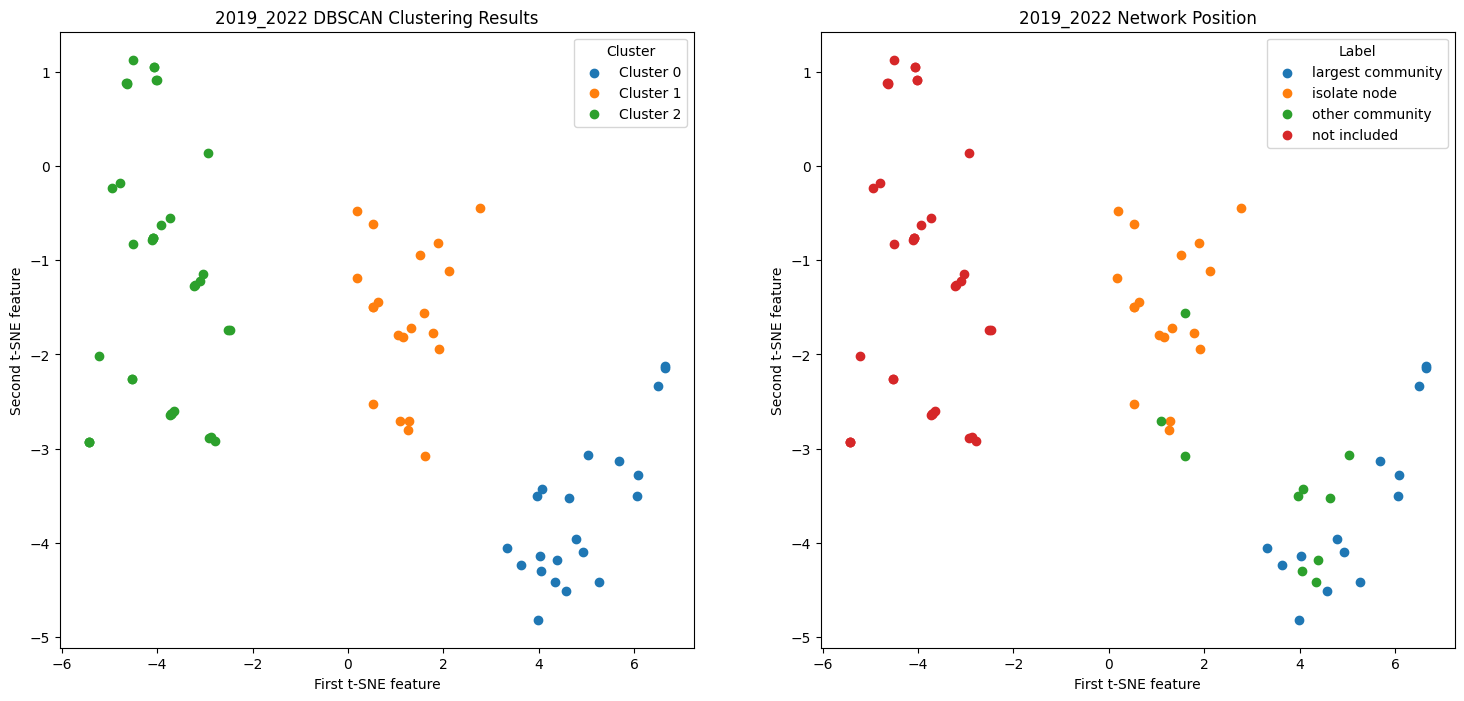

In [14]:
for p in ['2004_2008', '2009_2013', '2014_2018', '2019_2022']:
    # extract period
    df_p = df.loc[df['時期']==p,]
    df_p = df_p.drop(['專利權人','國家','時期','position_class'], axis = 1)

    # Scale the data
    scaler = StandardScaler()
    df_p = scaler.fit_transform(df_p)

    # t-SNE transform
    tsne = TSNE(random_state=42)
    X = tsne.fit_transform(df_p)
    
    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=1.5, min_samples=8)
    df_temp = pd.DataFrame({'cluster':dbscan.fit_predict(X)})

    # Convert original labels to numeric values for comparison
    df_label = df.loc[df['時期']==p,'position_class'].reset_index(drop=True)
    label_map = {label: idx for idx, label in enumerate(df_label.unique())}
    df_temp['label_num'] = df_label.map(label_map)
    df_temp['label'] = df_label

    X_df = pd.DataFrame(X)
    df_temp2 = pd.concat([X_df, df_temp], axis = 1)

    # Map clusters to colors, including noise as a separate color
    unique_clusters = df_temp2['cluster'].unique()
    colors = plt.cm.tab10(range(len(unique_clusters))) 
    cluster_color_map = {cluster: colors[i] for i, cluster in enumerate(unique_clusters) if cluster != -1}
    cluster_color_map[-1] = 'black'  # color for noise

    # Map labels to colors
    unique_labels = df_temp2['label_num'].unique()
    colors = plt.cm.tab10(range(len(unique_labels))) 
    label_color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

    # Create the figure and axes for the subplots
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))

    # Scatter plot for DBSCAN clustering results
    for cluster in unique_clusters:
        subset = df_temp2[df_temp2['cluster'] == cluster]
        ax[0].scatter(subset.iloc[:,0], subset.iloc[:,1], c=[cluster_color_map[cluster]], label=f'Cluster {cluster}')
    ax[0].set_xlabel('First t-SNE feature')
    ax[0].set_ylabel('Second t-SNE feature')
    ax[0].set_title(f'{p} DBSCAN Clustering Results')
    ax[0].legend(title='Cluster')

    # Scatter plot for original labels
    for label in unique_labels:
        subset = df_temp2[df_temp2['label_num'] == label]
        netpos_label = subset.loc[subset['label_num'] == label,'label'].unique()[0]
        ax[1].scatter(subset.iloc[:,0], subset.iloc[:,1], c=[label_color_map[label]], label=netpos_label)
    ax[1].set_xlabel('First t-SNE feature')
    ax[1].set_ylabel('Second t-SNE feature')
    ax[1].set_title(f'{p} Network Position')
    ax[1].legend(title='Label')

    # Show the plots
    plt.show()

To visualize the clustering results from DBSCAN and compare them to network positions, we use a t-SNE transformed 2D feature space to illustrate the distribution of data points, coloring them according to their assigned clusters or position classes. We observed that DBSCAN effectively captures 'not included' and 'isolates' groups and occasionally captures most data points in the 'largest community'. However, it still struggles to distinguish between the 'largest community' and 'other community'.

## Conclusion

From the findings above, we can conclude that network position classification based on global network structure and community detection is difficult to capture using unsupervised clustering algorithms with node-level attributes and centralities as input features. While these clustering algorithms can identify some relatively straightforward parts of the network, distinguishing structural position differences in dense and complex network components is nearly impossible with only node-level features. This indicates the necessity of directly analyzing the network structure to identify different clustering positions with strategic significance.